
# Problem 2
## Daniel Lapido Martínez

### Find and describe a problem (realistic or not) where the decision making process requires of the formulation of a linear optimization model with at least 10 decision variables.

Gambling (also known as betting) is the wagering of money or something of value (referred to as "the stakes") on an event with an uncertain outcome, with the primary intent of winning money or material goods. One example of that are sports betting which represents a multi-billion dollar business generating huge profits for sportsbooks and casinos worldwide.

The reason for being so profitable is because the odds on display never reflect the true probability or chance of an event occurring (or not occurring). There is always a profit margin added by the bookmaker in these odds, which means that the payout to the successful punter is always less than what they should have received if the odds had reflected the true chances. The bookmaker estimates the true probability or chance of an outcome correctly in order to set the odds on display in such a way that it profits the bookmaker regardless of an event outcome. 

Through this notebook we will focush on the spanish football league betting industry and my work will consist in implementing in pyomo an approach to football betting that handles risk based on robust optimization. For this purpose I will follow the next steps:

<ol>
<li> Build a statistical model to predict the probability of an outcome with data from the last seasons.
<li> Analize the different betting houses' odds and decide which betting house is better to bet on.
<li> Formulate the problem and solve it through robust optimization(worst case view, given the inherent uncertainty of the problem) and decide how much to bet on each game.</li>
</ol>

We will start by solving the problem with linear robust optimization, then we will add some extra conditional constraints, and finally we will try a stochastic programming formulation.
    
**Important notes:**
<li> I will be using real data that comes from the webpage: <a>https://www.football-data.co.uk/spainm.php</a>. 
<li> Although it is possible to bet on multitude of events like number of goals, number of corners and so on, I will only consider the outcome of the match.
<li> Matches are considered to be <font color="red">simultaneously played </font>.
<li> Since the problem is a little bit ambitious, I will make several assumptions to simplify things, especially regarding the statistical model so that we can focush in the optimization problem. </li> 



### 1. The data

The datasets contain information about football games from the Spanish League (First Division). There are lots of columns but we will focush just on the Home and Away teams,
the goals that each team scores, the full time results and the odds of the betting houses.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam

liga_1920 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1920/SP1.csv")

liga_1819 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1819/SP1.csv")
liga_1718 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1718/SP1.csv")
liga_1617 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1617/SP1.csv")
liga_1516 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1516/SP1.csv")
liga_1415 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1415/SP1.csv")
liga_1314 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1314/SP1.csv")
liga_1213 = pd.read_csv("https://www.football-data.co.uk/mmz4281/1213/SP1.csv")

seasons = [liga_1819, liga_1718, liga_1617, liga_1516, liga_1415, liga_1314, liga_1213]
last_seasons = pd.concat(seasons, sort=False, ignore_index=True)
last_seasons = last_seasons[['HomeTeam','AwayTeam','FTHG','FTAG','FTR',"B365H", "B365D","B365A", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA","WHH", "WHD", "WHA"]]

last_seasons.head(5)

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,WHH,WHD,WHA
0,Betis,Levante,0,3,A,1.66,4.0,5.0,1.70,3.7,5.25,1.75,3.6,4.9,1.67,3.9,4.75
1,Girona,Valladolid,0,0,D,1.75,3.6,5.0,1.75,3.5,5.25,1.80,3.6,4.5,1.75,3.6,4.60
2,Barcelona,Alaves,3,0,H,1.11,10.0,21.0,1.11,10.0,20.00,1.12,9.0,20.0,1.08,9.0,29.00
3,Celta,Espanol,1,1,D,1.85,3.5,4.5,1.91,3.4,4.25,1.90,3.5,4.1,1.91,3.5,4.00
4,Villarreal,Sociedad,1,2,A,2.04,3.4,3.8,2.05,3.3,3.90,2.00,3.4,3.8,2.05,3.3,3.60


### 2. Predicting the outcome

The models used by the betting houses are very powerfull, so we are not going to outperform them. I will use a very simple poisson model to predict the number of goals scored by each team and based on that select which one will win. 


Assumptions for the poisson model:

- The number of events is independent of time. (It is not true in real games)
- Goals don't become more/less likely by the number of goals already scored in the match (It is not true in real games)
- The opponent that a team is facing is important for the number of goals.
- Teams behave more or less the same through the seasons

In [6]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_data = pd.concat([last_seasons[['HomeTeam','AwayTeam','FTHG']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'rival','FTHG':'goals'}),
           last_seasons[['AwayTeam','HomeTeam','FTAG']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'rival','FTAG':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + rival", data=goal_data, 
                        family=sm.families.Poisson()).fit()
# poisson_model.summary()


Function to simulate matches with the model:

In [128]:
def predict_match(model, homeTeam, awayTeam, max_goals=10):
    """This function returns the probability of an outcome by generating the probabilities of scoring certain numbers of goals"""
    
    home_goals_avg = model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'rival': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'rival': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    
    # Matrix of goals probabilities:
    # Elements of the diagonal represent probabilities of scoring the same number of goals (0-0), (1,1)..
    # Elementes below the diagonal represent probabilities where the home team scored more goals (the sum of these elements is the probability of home team victory)
    # Elementes above the diagonal represent probabilities where the away team scored more goals (the sum of these elements is the probability of away team victory)
    matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    predicted_odds = pd.DataFrame(data={'Home win': np.sum(np.tril(matrix, -1)), 'Draw': np.sum(np.diag(matrix)),'Away win':np.sum(np.triu(matrix, 1))}, index=[1])
    return(predicted_odds)

predict_match(poisson_model, "Barcelona", "Huesca")

,Home win,Draw,Away win
1,0.908902,0.062037,0.026956


Next we predict the whole 2019-2020 season:

In [129]:
def predict_season(season):
    """This function predict the outcome of all the matches in a season with a certain probability"""
    predictions = pd.DataFrame(columns=['Home win','Draw','Away win','Max probability', 'Predicted result'], index = range(len(season)))
    for i in range(len(season)):
        result = predict_match(poisson_model, season["HomeTeam"][i], season["AwayTeam"][i]).iloc[0,:].values.tolist()
        result.append(max(result))
        if result.index(max(result)) == 0:
            result.append("H")
        elif result.index(max(result)) == 1:
            result.append("D")
        elif result.index(max(result)) == 2:
            result.append("A")
        predictions.iloc[i,:] = result
    
    return(predictions)
    

    

In [9]:
simulated_season = predict_season(liga_1920)
simulated_season

,Home win,Draw,Away win,Max probability,Predicted result
0,0.169472,0.205109,0.625408,0.625408,A
1,0.184762,0.186157,0.629039,0.629039,A
2,0.522568,0.236178,0.241252,0.522568,H
3,0.34208,0.256329,0.40159,0.40159,A
4,0.546329,0.268124,0.185547,0.546329,H
...,...,...,...,...,...
265,0.334187,0.288125,0.377688,0.377688,A
266,0.535611,0.253644,0.210745,0.535611,H
267,0.572425,0.2645,0.163075,0.572425,H
268,0.152816,0.173169,0.673949,0.673949,A


Lets see how good are the predictions for 2019-2020 season:

In [11]:
pd.crosstab(liga_1920.loc[:,"FTR"], simulated_season.loc[:,"Predicted result"], rownames=['Actual'], colnames=['Predicted'])

Predicted,A,H
Actual,,
A,30,36
D,23,52
H,30,99


The model is never confident enough to predict a draw and it does not have a good accuracy overall $(48\%)$. We might want to avoid betting in those cases where the most probable outcome does not have a probability above a certain threshold ($50\%$ or more). Of course we do not know if we have correctly predicted the actual outcome beforehand, so this uncertainty is inherent to the problem.

### 3. Betting houses

Now that we have a model to predict the outcome, lets analyze the betting houses. There are tons of betting houses so lets keep it simple and stick with the most famous ones and select just one to bet on (We could have made the problem even more complex by allowing bets on different betting houses)

We start by converting the odds into implied probabilities:

In [13]:
def probability(column1, column2, column3):
    """This function converts the odds into implied probability"""
    prob1=1/column1
    prob2=1/column2
    prob3=1/column3
    prob=prob1+prob2+prob3
    return(prob)


liga_1920["Bet365"] = probability(liga_1920["B365H"], liga_1920["B365D"], liga_1920["B365A"])
liga_1920["Bet_Win"] = probability(liga_1920["BWH"], liga_1920["BWD"], liga_1920["BWA"])
liga_1920["Interwetten"] = probability(liga_1920["IWH"], liga_1920["IWD"], liga_1920["IWA"])
liga_1920["William_Hill"] = probability(liga_1920["WHH"], liga_1920["WHD"], liga_1920["WHA"])


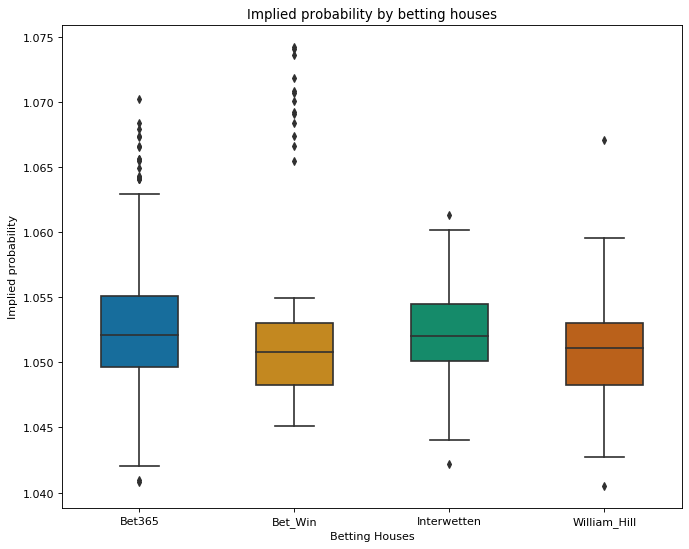

In [14]:
import plotly.express as px
bettinghouses=liga_1920.loc[:,["Bet365","Bet_Win","Interwetten","William_Hill"]]
meltdata=pd.melt(bettinghouses)

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.boxplot(y='value', x='variable', 
                 data=meltdata, 
                 width=0.5,
                 palette="colorblind")
plt.title("Implied probability by betting houses")
plt.xlabel("Betting Houses")
plt.ylabel("Implied probability")
plt.show()

We can see that some houses tend to have a larger profit margin, so we should probably stay with BetWin.

### 4. Optimization for the betting problem

#### a) (2 points) Formulate the problem as a linear optimization model (general formulation). Identify the model sets, parameters, variables, objective function and constraints.

With a large number of simultaneous bets, we use
the overall accuracy of the predictive model to optimize the worst case gain:

- Identify a set of $N$ soccer games on which we want to bet

- Fix a maximum budget to spend $B$

- The bookmakers’ odds for every game represent the return on a unit stake and denoted $c_{i}$

- Lets assume that the Poisson model gives good estimates on the probability of each game $p_{i}$

- Comparing these probabilities $p_{i}$ with the odds $c_{i}$, we need to decide how to allocate the budget among the different games.

- The decision variables $x_{i},  \ i \in \{1, 2,... N \}$ are the amount of money to bet on game $i$

- We have a Budget constraint: $\sum_{i=1}^{N} x_{i} \leq B $

- Once a bet $x_{i}$ is set on game $i$, there are two possible outcomes: We either predicted the result correctly and win according to the bookmakers’ odds, or our prediction was wrong and we lose all the money:

$$
\text{P}_{i}=
\left\{\begin{array}{ll} 
(c_{i} - 1)x_{i}, & \text{if we predict correctly the outcome of game i,}\\
-x_{i}, & \text{if we do not predict correctly the outcome}
\end{array} \right.
$$

The profit of the game is obviously a random variable $(P_{i})$ and the total profit can be obtained as the sum of the profits over all the games: $P = \sum_{i=1}^{N} P_{i}$

The problem is that the outcome of the match is obviously unknown, so we can either be correct or wrong:

$$
y_{i}=
\left\{\begin{array}{ll} 
1, & \text{if we predict correctly the outcome of game i,}\\
0, & \text{if we do not predict correctly the outcome}
\end{array} \right.
$$

This variable clearly belongs to an uncertainty set $\Omega$ (we do not know how many outcomes we are going to correctly predict, however we are going to assume that we will not be always wrong)

This way we can try to optimize the worst case scenario:
\begin{align*}
\normalsize
z = \underset{x_{i}}{maximize} & \quad \normalsize(\underset{y_{i} \in \Omega}{minimize} (\sum_{i}^{N} x_{i}c_{i}y_{i} - x_{i}) )
\end{align*}

Now we need to build the uncertainty set $\Omega$:

In the worst case scenario, all $y_{i}$ would be set to zero, however we assume that the model is not completely useless so that it has a 'worst case' accuracy.
Lets call this accuracy $\kappa$, and say that it is $30\%$ for example. That means that in a worst case scenario the model at least correctly predict the outcome of $\kappa \cdot N \equiv \Theta$ games. This way we can set the following constraint in the uncertainty set: 

$$\sum_{i=1}^{N} y_{i} \geq \Theta $$

Now we incorporate another constraint that takes into account the probability $p_{i}$ of an event so that it is more difficult to predict wrong an outcome
when its predicted probability is very high:

$$\sum_{i}^{N} p_{i}y_{i} \geq \Phi$$

Finally the uncertainty set is:

$$\Omega = \{y \in \{0, 1\}^{N} | \sum_{i=1}^{N} y_{i} \geq \Theta , \sum_{i}^{N} p_{i}y_{i} \geq \Phi  \}$$

Ideally the parameters $\Theta$ and $\Phi$ would be perfectly chosen but in this case we will just set them by hand.

Now another problem arises since the uncertainty set is not convex but discrete so we will solve a linear relaxation of the problem and just give a lower bound on the optimal cost.


**Linear relaxation of a subproblem**

\begin{align*}
\normalsize
\underset{y}{minimize} & \quad \sum_{i=1}^{N} c_{i}x_{i}y_{i}\\
\text{Subject to:}&\\
  & \sum_{i=1}^{N} y_{i} \geq \Theta \\
  & \sum_{i}^{N} p_{i}y_{i} \geq \Phi\\
  & y_{i} \leq 1 \\
  & y_{i} \geq 0
\end{align*}

**Dual problem** 

\begin{align*}
\normalsize
\underset{\alpha,\beta, g}{maximize} & \quad \Theta \alpha + \Phi  \beta -  \sum_{i=1}^{N} g_{i}\\
\text{Subject to:}&\\
  & \alpha + \beta - g_{i} \leq c_{i}x_{i} \forall i \\
  & \alpha, \beta, g \geq 0 \\
\end{align*}


If we join this maximization problem with the original one we get the Robust counterpart of the relaxation problem:

**Linear relaxation problem**


\begin{align*}
\normalsize
z_{relax} = \underset{\alpha,\beta, g}{maximize} & \quad \Theta \alpha + \Phi  \beta -  \sum_{i=1}^{N} g_{i} - \sum_{i=1}^{N} x_{i}\\
\text{Subject to:}&\\
  & \alpha + \beta - g_{i} \leq c_{i}x_{i} \forall i \\
  &\sum_{i=1}^{N} x_{i} \leq B \\
  & \alpha, \beta, g, x \geq 0 \\
\end{align*}

Since $z_{relax} \leq z_{robust}$ , solving this problem is very useful for our purpose.



#### b) (3 points) Implement the model in Pyomo as an “AbstractModel()” and solve it for a set of values (parameter values) based on real world data. Compute the sensitivities associated with each constraint, and interpret their values.


In [15]:
N = len(liga_1920.loc[:,"FTR"].iloc[np.where(simulated_season.loc[:,"Max probability"] >= 0.7)]) # We are only going to bet in those games where we are somewhat confident on the result

B = 500 # Maximum Budget

liga_1920_ = liga_1920.iloc[np.where(simulated_season.loc[:,"Max probability"] >= 0.7)]

# We need to extract the odds of BetWin for the outcomes we predicted (c_{i})
FTR_predictions = list(simulated_season.loc[:,"Predicted result"].iloc[np.where(simulated_season.loc[:,"Max probability"] >= 0.7)])
c = []
for i in range(len(FTR_predictions)):
    if FTR_predictions[i] == 'H':
        c.append(list(liga_1920_["BWH"])[i])
    elif FTR_predictions[i] == 'A':
        c.append(list(liga_1920_["BWA"])[i])
    elif FTR_predictions[i] == 'D':
        c.append(list(liga_1920_["BWD"])[i])
        
# Predicted probabilities for the outcomes
p = list(simulated_season.loc[:,"Max probability"].iloc[np.where(simulated_season.loc[:,"Max probability"] >= 0.7)])

kappa = 0.3 # Worst case scenario accuracy

theta = kappa*N # minimum number of correctly predicted games (In this case 30% of 270 ~ 80 games)

phi = 40 # The average maximum probability of the model is around 50%

Now we implement the model in Pyomo as an “AbstractModel()”:

In [130]:
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

model = AbstractModel()


model.I = RangeSet(0,N-1) 


# Continuous variables:
model.x = Var(model.I, domain=NonNegativeReals)
model.g = Var(model.I, domain=NonNegativeReals)
model.alpha = Var(domain=NonNegativeReals)
model.beta = Var(domain=NonNegativeReals)

#definition of the objective function
def obj_expression(model): 
    return theta*model.alpha + phi*model.beta - sum(model.g[i] for i in model.I) - sum(model.x[i] for i in model.I)

model.OBJ = Objective(rule=obj_expression, sense=maximize)


# First constraint:
def first_constraint(model, i):
    return model.alpha + model.beta - model.g[i] <= c[i]*model.x[i]

model.first_constraint = Constraint(model.I, rule=first_constraint)

# Budget constraint:
def budget_constraint(model):
    return sum(model.x[i] for i in model.I) <= B

model.budget_constraint = Constraint(model.I, rule=budget_constraint)




In [131]:
instance = model.create_instance()
# Create a 'dual' suffix component on the instance
# so the solver plugin will know which suffixes to collect
instance.dual = Suffix(direction=Suffix.IMPORT)
results = opt.solve(instance)
instance.x.display()
# instance.pprint()
# print(results)

x : Size=46, Index=I
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
      0 :     0 : 11.6534603622737 :  None : False : False : NonNegativeReals
      1 :     0 : 14.0812646044141 :  None : False : False : NonNegativeReals
      2 :     0 : 13.5180140202375 :  None : False : False : NonNegativeReals
      3 :     0 :  12.516679648368 :  None : False : False : NonNegativeReals
      4 :     0 :  12.069655375212 :  None : False : False : NonNegativeReals
      5 :     0 :  12.069655375212 :  None : False : False : NonNegativeReals
      6 :     0 : 13.5180140202375 :  None : False : False : NonNegativeReals
      7 :     0 : 11.4172415711465 :  None : False : False : NonNegativeReals
      8 :     0 : 11.8996602290823 :  None : False : False : NonNegativeReals
      9 :     0 : 12.6100877054454 :  None : False : False : NonNegativeReals
     10 :     0 : 12.9980904040745 :  None : False : False : NonNegativeReals
     11 :     0 : 13.5180140202375 :  None : False : 

We have obtained a solution for $x$ that tells us how much to bet on each game assuming the worst case scenario. The good news is that the lower bound 
for the profit in this scenario is positive, which means that we will win money. Under the assumptions made for the uncertainty set, we will at least gain 91 euros.

In [132]:
instance.OBJ.display()

OBJ : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 91.41311338539185


#### Sensitivity analysis:

We are mostly interested in the budget constraint since the other one do not give valuable information:

In [133]:
# display all dual for budget constraint:
i=0
for cons in instance.component_objects(Constraint, active=True):
    if i==1:
        print ("   Constraint:",cons)
        print ("Dual for Budget =", instance.dual[cons[0]])
    i+= 1 

   Constraint: budget_constraint
Dual for Budget = 0.182826226770781


This is basically saying that for every unit that we increase the Budget, we will earn 0.18 euros more (No matter how much we increase $B$ this holds). 

Regardless of the good result, we must be aware that the way we constructed the uncertainty set , was assuming that we are not likely to be wrong in those cases where the predicted probability is high. We are being **confident** on our probabilities.

However we have seen that the model that we are using is not able to predict Draws at all and events that a priori are very unlikely also end up happening in soccer. That means that in those games where big teams are playing (like Barcelona or Real Madrid) we could lose a lot of money if they lose or the result is a Draw. In other words, there could be worse scenarios than the proposed *worst case scenario*.

For example, if we had used this solution to bet in the season 19-20 the gain would be:

In [20]:
x_worst_case = []
for I in instance.I:
    x_worst_case.append(instance.x[I].value)

def true_total_return():
    gain=[]
    for i in range(len(liga_1920_)):
        if FTR_predictions[i]== list(liga_1920_.loc[:, "FTR"])[i]:
            gain.append(c[i]*x_worst_case[i]-x_worst_case[i])
        else:
            gain.append(-x_worst_case[i])
    return(gain)
            
gain = true_total_return() 
np.sum(gain)

6.925525758905783

Just 7 euros of profit having a 500 budget is an irrisory return. In the next part we will see that those really unlikely events are the responsible for this.

### (3 points) Modify the problem in a) to impose some logical or conditional constraints (linear) that require the use of binary or integer variables. Implement and solve this new model in Pyomo as an “AbstractModel()” and interpret the results.

We have seen that our model is bad, so the next step is not going to make things better. However,  <font color="red">lets imagine that we have a competent model that can challenge 
those of the bookmakers</font>.

If that was the case, then we would be able to predict the *true probabilities* of the events and we would be able to detect situations where the market has underestimated the chances of an event occurring.
This means that we would have an *edge* over the bookmakers and we could choose to bet on some profitable events. If the bookmaker is overestimating the chances of an event occuring we might not want to bet.

What we can do is to set a conditional constraint so that if the predicted probability $p_{i}$ is below the bookmakers' probability ($1/c_{i}$), then the amount of money that we bet on game $i$ is equal to zero, since the exchange they are giving is less than what it should be.

The binary variable $z_{i}$ decides if we must bet on game $i$ or not:

The following pair of constraints satisfy that if $p_{i} \geq 1/c_{i} \rightarrow z_{i} = 1$, else $z_{i}=0$ 

\begin{align*}
\normalsize
& 1/c_{i} \leq p_{i} + M(1-z_{i}) \quad \forall i \\
& 1/c_{i} > p_{i} - Mz_{i} \quad \forall i
\end{align*}

Where we set $M > 1$ to assure that they hold.

We just need to set that if $z_{i}=0$ then we do not bet any money. The final problem looks like this:


\begin{align*}
\normalsize
z_{relax} = \underset{\alpha,\beta, g}{maximize} & \quad \Theta \alpha + \Phi  \beta -  \sum_{i=1}^{N} g_{i} - \sum_{i=1}^{N} x_{i}\\
\text{Subject to:}&\\
  & \alpha + \beta - g_{i} \leq c_{i}x_{i} \forall i \\
  &\sum_{i=1}^{N} x_{i} \leq B \\
  & 1/c_{i} \leq p_{i} + M(1-z_{i}) \quad \forall i \\
  & 1/c_{i} > p_{i} - Mz_{i} \quad \forall i \\
  & x_{i} \leq Bz_{i} \quad \forall i \\
  & \alpha, \beta, g, x \geq 0 \\
\end{align*}

In [239]:

M = 10 # Garantees that third and fourth constraints hold

newmodel = AbstractModel()

newmodel.I = RangeSet(0,N-1) 


# Continuous variables:
newmodel.x = Var(newmodel.I, domain=NonNegativeReals)
newmodel.g = Var(newmodel.I, domain=NonNegativeReals)
newmodel.alpha = Var(domain=NonNegativeReals)
newmodel.beta = Var(domain=NonNegativeReals)

# Binary variable
newmodel.z = Var(newmodel.I, domain=Binary)

#definition of the objective function
def obj_expression(newmodel): 
    return theta*newmodel.alpha + phi*newmodel.beta - sum(newmodel.g[i] for i in newmodel.I) - sum(newmodel.x[i] for i in newmodel.I)

newmodel.OBJ = Objective(rule=obj_expression, sense=maximize)


# First constraint:
def first_constraint(newmodel, i):
    return newmodel.alpha + newmodel.beta - newmodel.g[i] <= c[i]*newmodel.x[i]

newmodel.first_constraint = Constraint(newmodel.I, rule=first_constraint)

# Budget constraint:
def budget_constraint(newmodel):
    return sum(newmodel.x[i] for i in newmodel.I) <= B

newmodel.budget_constraint = Constraint(newmodel.I, rule=budget_constraint)

# Third constraint:
def third_constraint(newmodel, i):
    return p[i] + M*(1-newmodel.z[i]) >= 1/c[i]

newmodel.third_constraint = Constraint(newmodel.I, rule=third_constraint)

# Fourth constraint:
def fourth_constraint(newmodel, i):
    return p[i] - M*newmodel.z[i] <= 1/c[i]

newmodel.fourth_constraint = Constraint(newmodel.I, rule=fourth_constraint)

# Fifth constraint:
def fifth_constraint(newmodel, i):
    return newmodel.x[i] <= B*newmodel.z[i]

newmodel.fifth_constraint = Constraint(newmodel.I, rule=fifth_constraint)


In [240]:
instance2 = newmodel.create_instance()
# Create a 'dual' suffix component on the instance
# so the solver plugin will know which suffixes to collect
instance2.dual = Suffix(direction=Suffix.IMPORT)
results2 = opt.solve(instance2)
instance2.x.display()
# instance2.pprint()
# print(results)

x : Size=46, Index=I
    Key : Lower : Value            : Upper : Fixed : Stale : Domain
      0 :     0 : 13.4002743269838 :  None : False : False : NonNegativeReals
      1 :     0 : 16.1919981451054 :  None : False : False : NonNegativeReals
      2 :     0 : 15.5443182193012 :  None : False : False : NonNegativeReals
      3 :     0 : 14.3928872400937 :  None : False : False : NonNegativeReals
      4 :     0 : 13.8788555529475 :  None : False : False : NonNegativeReals
      5 :     0 : 13.8788555529475 :  None : False : False : NonNegativeReals
      6 :     0 : 15.5443182193012 :  None : False : False : NonNegativeReals
      7 :     0 :   13.12864714468 :  None : False : False : NonNegativeReals
      8 :     0 : 13.6833787141736 :  None : False : False : NonNegativeReals
      9 :     0 :  14.500296846363 :  None : False : False : NonNegativeReals
     10 :     0 :              0.0 :  None : False : False : NonNegativeReals
     11 :     0 : 15.5443182193012 :  None : False : 

We can see that now we are avoiding to bet in more games. The *worst* case profit is smaller than before but at least we are not losing money.

In [241]:
instance2.OBJ.display()

OBJ : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 82.9119332237949


Following this strategy in the 19-20 season we would have obtained:

In [24]:
x_worst_case = []
for I in instance2.I:
    x_worst_case.append(instance2.x[I].value)

def true_total_return():
    gain=[]
    for i in range(len(liga_1920_)):
        if FTR_predictions[i]== list(liga_1920_.loc[:, "FTR"])[i]:
            gain.append(c[i]*x_worst_case[i]-x_worst_case[i])
        else:
            gain.append(-x_worst_case[i])
    return(gain)
            
gain = true_total_return() 
np.sum(gain)

5.190342127287929

Even less profit than before but we still did not lose money.  The following table presents those rare games that prevented us from making more money:

In [134]:
games = liga_1920_.loc[:, "FTR"].index.values
loses = np.where(np.array(gain)<0)
problematic_matches = games[loses]
teams = liga_1920.iloc[problematic_matches,:]
teams = teams.loc[:,["Date","HomeTeam", "AwayTeam","FTR"]]
teams.reset_index(drop=True, inplace=True)
data1 = pd.DataFrame(np.array(gain)[loses])
data1.columns=["Money losses"]

pd.concat([data1,teams], sort=False, axis=1)

,Money losses,Date,HomeTeam,AwayTeam,FTR
0,-16.191998,24/08/2019,Real Madrid,Valladolid,D
1,-14.392887,31/08/2019,Osasuna,Barcelona,D
2,-13.683379,21/09/2019,Ath Madrid,Celta,D
3,-14.500297,21/09/2019,Granada,Barcelona,H
4,-13.128647,19/10/2019,Mallorca,Real Madrid,H
5,-15.420951,02/11/2019,Real Madrid,Betis,D
6,-14.287057,22/12/2019,Real Madrid,Ath Bilbao,D
7,-13.400274,04/01/2020,Espanol,Barcelona,D
8,-13.400274,26/01/2020,Ath Madrid,Leganes,D
9,-15.420951,16/02/2020,Real Madrid,Celta,D


A possible approach to avoid this is would have been to build the uncertainty set in such a way that we are not so confident on our predicted probabilities.

### d) Assume now that one or some of the model parameters in a) are uncertain, and decisions need to be made facing this uncertainty.

#### i) (1.5 points) Propose a stochastic programming formulation for the problem presented in a): Identify the first- and second-stage decision variables, generate an adequate set of random scenarios for the uncertain parameters and solve the resulting model in PyomoPython. Interpret the results.


Since the beginning we have been dealing with uncertainty with a robust approach for the parameter $y_{i}$ (whether we correctly predicted or not the outcome of game $i$), however once that $y_{i}$ is known there is no decision we can make. We can reformulate the problem so that it allows a Stochastic programming formulation by <font color="red">**assuming that the games are not simultaneous but sequential**</font>. What we did before was assume the games were all played at once, now we are assuming that none of the games are played at the same hour (which is true except for the final day of the season, where all teams play at the same time).


We have $N=270$ games in the la liga 19-20 season (there was no final game because of the COVID19 outbreak), so there are 270 stages.

- We can represent the initial budget at the beginning of stage $n$ by $B_{n}$.
- The decision at stage $n$ is what fraction of the budget to bet $\alpha_{n}$ (There are 270-stage decision variables)
- Lets assume that our model is very strong (which again, is not) and is **able to predict the true probability of the outcomes** $p_{i}$
- According to the profit random variable, we can go from one state to another with:

$$
\text B_{n+1}=
\left\{\begin{array}{ll} 
c_{n}\alpha_{n} B_{n}, & \text{if we win $(p_{i})$,}\\
B_{n} - \alpha_{n}B_{n}, & \text{if we lose $(1-p_{i})$}
\end{array} \right.
$$


What it is usually done in this cases is to try to optimize a utility function of the expected profit. The most common one is the log-utility function (optimize the logarithm of the expected profit), however the objective would be non-linear and *glpk* is not able to solve it, so we would have to rely on other solvers. Instead we will just try to optimize the expected profit (and discuss why we should not do that in the long run).

The optimization problem at each stage is to maximize the expected return. Let $V_{n}(x)$ denote the maximal expected return if we have a present budget of $B_{n}$

\begin{align*}
\normalsize
V_{n+1} = \underset{\alpha}{maximize} & \quad [p_{i}V_{n}(c_{n}\alpha_{n}B_{n}) + (1-p_{i})V_{n}(B_{n} - \alpha_{n}B_{n}) ]\\
\text{Subject to:}&\\
  & 0 \leq \alpha_{n} \leq R \quad \forall n \\
  &V_{0} = log B_{0} \\
\end{align*}

We impose a risk threshold because the best strategy is to allocate the entire budget to the event with the highest
expected gain. (Without the utility function we are not really dealing with uncertainty)

In [259]:
stochmodel = AbstractModel()    

R = 0.6 #Risk threshold
q = p[0]-(1-p[0])
# Continuous variable:
stochmodel.alpha = Var(within=NonNegativeReals,bounds=(0, R), initialize=q)

#definition of the objective function
def obj_expression(stochmodel): 
    return prob*V*(odds*stochmodel.alpha*b) + (1-prob)*V*(b - stochmodel.alpha*b)

stochmodel.OBJ = Objective(rule=obj_expression, sense=maximize)


In [260]:
# We get warnings because we did not set any constraints on the model, so I disable pyomo warnings
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

minimum_prob = 0.7 # We are only going to bet in those games where we are somewhat confident on the result

N = len(liga_1920.loc[:,"FTR"].iloc[np.where(simulated_season.loc[:,"Max probability"] >= minimum_prob)]) 

B = 500 # Maximum Budget

liga_1920_ = liga_1920.iloc[np.where(simulated_season.loc[:,"Max probability"] >= minimum_prob)]

# We need to extract the odds of BetWin for the outcomes we predicted (c_{i})
FTR_predictions = list(simulated_season.loc[:,"Predicted result"].iloc[np.where(simulated_season.loc[:,"Max probability"] >= minimum_prob)])
c = []
for i in range(len(FTR_predictions)):
    if FTR_predictions[i] == 'H':
        c.append(list(liga_1920_["BWH"])[i])
    elif FTR_predictions[i] == 'A':
        c.append(list(liga_1920_["BWA"])[i])
    elif FTR_predictions[i] == 'D':
        c.append(list(liga_1920_["BWD"])[i])
        
# Predicted probabilities for the outcomes
p = list(simulated_season.loc[:,"Max probability"].iloc[np.where(simulated_season.loc[:,"Max probability"] >= minimum_prob)])



Budget = [] # Vector where we store the Budget at the beginning of every game
Budget.append(500) # Initial budget
Vn = []
Vn.append(log(Budget[0]))
alphas = []

for i in range(N):
    b = Budget[i]
    prob = p_all[i]
    q = p_all[i]-(1-p_all[i])
    V = Vn[i]
    odds = all_odds[i]
    instance3 = stochmodel.create_instance()
    results3 = opt.solve(instance3)
    Vn.append(value(instance3.OBJ))
    alphas.append(instance3.alpha.value)
    
    if FTR_predictions[i] == list(liga_1920_.loc[:, "FTR"])[i]:
            Budget.append(odds*alphas[i]*Budget[i]) # We win
    else:
            Budget.append(Budget[i] - alphas[i]*Budget[i]) # We lose the bet             

In [261]:
stoch_results = pd.concat([pd.DataFrame(alphas), pd.DataFrame(Budget)], axis=1)
stoch_results.columns=["Fraction of total budget risked", "Total Budget before betting"]

pd.options.display.float_format = '{:.11f}'.format
stoch_results

,Fraction of total budget risked,Total Budget before betting
0,0.60000000000,500.00000000000
1,0.60000000000,495.00000000000
2,0.60000000000,198.00000000000
3,0.60000000000,198.39600000000
4,0.60000000000,79.35840000000
5,0.60000000000,97.61083200000
6,0.60000000000,93.70639872000
7,0.60000000000,120.88125434880
8,0.60000000000,166.81613100134
9,0.60000000000,66.72645240054


Repeatedly betting this way will let us ruined almost surely in other random scenarios (the next seasons for example). 
Utility functions are necessary to somehow manage the risk or we could use the robust formulation of the beginning. Otherwise we would be only relying on the predictions of our toy model.

#### ii) (0.5 points) Compute the Expected Value of Perfect Information (EVPI) and the Value of the Stochastic Solution (VSS) associated to the optimal solution obtained in i).


We should have done the previous step implementing stochastic robust programming by mixing both two formulations and then generating random scenarios from the uncertainty set $\Omega$, but it was a little bit excessive.

Given the nature of the problem that I selected, the computation of the EVPI is really difficult. We are not able to calculate either the VSS since the "*proposed stochastic solution*" completely ignores uncertainty. However we can see the importance of including uncertainty if we compare the robust formulation (which handled uncertainty) with this last predicted approach. The profit with the robust formulation was of 6.92 euros, while the predicted approach yielded losses of 493 euros.

